# Lung Segmentation from Chest X-Ray using Segment Anything Model from Meta

In this notebook, we fine-tune the Segment Anything Model from Meta for segmentation of lungs from chest X-Ray images. The dataset for the training, validation and testing is downloaded from Kaggle. ("**nikhilpandey360/chest-xray-masks-and-labels**")

There are 800 chest X-Ray images and segmentation masks in the dataset. The dataset, downloaded directly from Kaggle was slightly modified to fit the SAM model input and for streamlining the data processing. The details can be found in the respective data processing step. In this notebook, I assume that the user has already cleaned up the dataset and created the train, valid and test splits needed to train the model. Out of 800 images, 640 are for training, 80 images are dedicated to validation and testing.

For this example, we are using the **sam-vit-base** model from meta. This model is appropriate for fine-tuning for a single GPU user. However, there are two larger models available from Meta, which users can use to potentially improve the performance.

In comparison to custom built RESNET model, I trained alongside, SAM-ViT-Base shows promise in terms of performance. Furthermore, larger models and with more data, SAM has the potential to be the SOTA in the filed of medical image segmentation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Image_Segmentation/best_model_weights.pth /content/

I had created the dataset from the Kaggle dataset and restructured it for this project. I saved it my google drive. I have provided the pre-processing script in the GitHub repository.

In [2]:
!cp /content/drive/MyDrive/chest_xray_dataset.zip /content/

In [ ]:
!unzip /content/chest_xray_dataset.zip

In [8]:
!mv ./chest_xray_dataset/* /content/

**Install and Import Libraries**

In [4]:
!pip install -q monai
!pip install -q SimpleITK
!pip install -q git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [6]:
!pip install Pillow

In [7]:
import os
import glob
import monai
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)

## Methods needed for generating the bounding box:

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import SamProcessor

import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


Define specific dataset for processing data. Two main factors here are, the images are in "RGB" and masks are 256 x 256.

In [10]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class SAMDataset(Dataset):
    def __init__(self, img_dir, mask_dir, processor):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.processor = processor
        self.images = sorted([os.path.join(img_dir, file) for file in os.listdir(img_dir)])
        self.masks = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path).convert("RGB")  # Ensure the image is RGB.

        # Open the mask image and convert it to grayscale
        mask = Image.open(mask_path).convert('L')

        # Convert the image to a numpy array
        ground_truth_mask = np.array(mask)

        # Ensure the mask is 2D right after loading and before any transformation.
        if len(ground_truth_mask.shape) != 2:
            raise ValueError(f"Mask at {mask_path} is not 2D. Shape found: {ground_truth_mask.shape}")

        # Normalize the mask to have values only 0 or 1
        ground_truth_mask = (ground_truth_mask > 0).astype(np.int8)

        # Convert the numpy array to a torch tensor
        ground_truth_mask = torch.from_numpy(ground_truth_mask).float()

        # Add a batch dimension (1, height, width) for interpolation
        ground_truth_mask = ground_truth_mask.unsqueeze(0).unsqueeze(0)

        # Resize the mask to 256x256 using PyTorch
        ground_truth_mask = F.interpolate(ground_truth_mask, size=(256, 256), mode='nearest')

        # Remove the batch dimension to get the final mask (1, 256, 256)
        ground_truth_mask = ground_truth_mask.squeeze(0).squeeze(0)

        # Ensure the mask is 2D.
        if len(ground_truth_mask.shape) != 2:
            raise ValueError(f"Mask at {mask_path} is not 2D. Shape found: {ground_truth_mask.shape}")

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(images=image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs


In [11]:
# Initialize the SAM processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Set your image and mask directories
train_img_dir = "/content/train_images"
train_mask_dir = "/content/train_masks"

# Set your image and mask directories
valid_img_dir = "/content/val_images"
valid_mask_dir = "/content/val_masks"

# Set your image and mask directories
test_img_dir = "/content/test_images"
test_mask_dir = "/content/test_masks"

# Create the dataset
train_dataset = SAMDataset(img_dir=train_img_dir, mask_dir=train_mask_dir, processor=processor)
# Create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Create the dataset
valid_dataset = SAMDataset(img_dir=valid_img_dir, mask_dir=valid_mask_dir, processor=processor)
# Create the DataLoader
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

# Create the dataset
test_dataset = SAMDataset(img_dir=test_img_dir, mask_dir=test_mask_dir, processor=processor)
# Create the DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


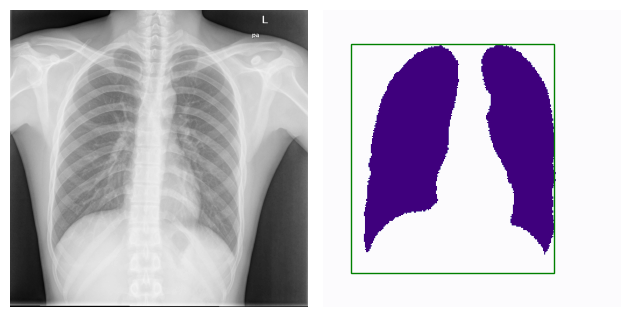

In [15]:
import torch.nn.functional as F
example = train_dataset[100]
for k,v in example.items():
    print(k,v.shape)

xmin, ymin, xmax, ymax = get_bounding_box(example['ground_truth_mask'])

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example['pixel_values'][1], cmap='gray')
axs[0].axis('off')

axs[1].imshow(example['ground_truth_mask'], cmap='Purples')

# create a Rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')

# add the patch to the second Axes
axs[1].add_patch(rect)

axs[1].axis('off')

plt.tight_layout()
plt.show()

Download the pre-trained "sam-vit-base" model and freeze the encoder weights.

In [18]:
# load the pretrained weights for finetuning
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Train:

LungLoss() is a custom loss function defined for this task. It is defined as the addition of three different losses, "BCE + jaccard_loss + dice_loss".

In [21]:
import torch
from torch.optim import Adam
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, patches
import pandas as pd

class lungLoss(nn.Module):
    """BCE, Jaccard_loss and Dice_loss"""
    def __init__(self, weight=None, size_average=True):
        super(lungLoss, self).__init__()

    def forward(self, outputs, targets, smooth=1e-8):
        outputs = torch.sigmoid(outputs)
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum() - intersection
        jaccard_loss = 1 - (intersection / (union + smooth))
        dice_loss = 1 - (2. * intersection) / (outputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(outputs, targets, reduction='mean')
        loss = BCE + jaccard_loss + dice_loss
        return loss

def calculate_metrics(outputs, targets, smooth=1e-8):
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    intersection = (preds * targets).sum()
    accuracy = (preds == targets).sum() / torch.numel(preds)
    dice = (2. * intersection) / (preds.sum() + targets.sum() + smooth)
    iou = intersection / (preds.sum() + targets.sum() - intersection + smooth)
    return accuracy.item(), dice.item(), iou.item()

# Initialize the model, optimizer, and loss function
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
loss_fn = lungLoss()

# Training parameters
num_epochs = 20
best_val_loss = float('inf')

# Initialize lists to store all epoch metrics
all_epoch_data = []

for epoch in range(num_epochs):
    model.train()
    train_losses, val_losses = [], []
    train_acc, train_dice, train_iou = [], [], []

    for batch in tqdm(train_dataloader):
        images = batch["pixel_values"].to(device)
        masks = batch["ground_truth_mask"].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        ground_truth_masks = ground_truth_masks.unsqueeze(1)
        if ground_truth_masks.ndim == 5:
            ground_truth_masks = ground_truth_masks.squeeze(2)
        ground_truth_masks = F.interpolate(ground_truth_masks, size=predicted_masks.shape[-2:], mode='nearest')
        loss = loss_fn(predicted_masks, ground_truth_masks)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate metrics
        accuracy, dice, iou = calculate_metrics(predicted_masks, ground_truth_masks)
        train_acc.append(accuracy)
        train_dice.append(dice)
        train_iou.append(iou)

    # Validation
    model.eval()
    val_acc, val_dice, val_iou = [], [], []
    with torch.no_grad():
        for val_batch in valid_dataloader:
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            ground_truth_masks = ground_truth_masks.unsqueeze(1)
            if ground_truth_masks.ndim == 5:
                ground_truth_masks = ground_truth_masks.squeeze(2)
            ground_truth_masks = F.interpolate(ground_truth_masks, size=predicted_masks.shape[-2:], mode='nearest')
            val_loss = loss_fn(predicted_masks, ground_truth_masks)
            val_losses.append(val_loss.item())

            # Calculate metrics
            accuracy, dice, iou = calculate_metrics(predicted_masks, ground_truth_masks)
            val_acc.append(accuracy)
            val_dice.append(dice)
            val_iou.append(iou)

    # # Calculate mean stats
    # mean_train_loss = np.mean(train_losses)
    # mean_val_loss = np.mean(val_losses)
    # mean_train_acc = np.mean(train_acc)
    # mean_train_dice = np.mean(train_dice)
    # mean_train_iou = np.mean(train_iou)
    # mean_val_acc = np.mean(val_acc)
    # mean_val_dice = np.mean(val_dice)
    # mean_val_iou = np.mean(val_iou)

    # print(f'Epoch [{epoch+1}/{num_epochs}]')
    # print(f'Train Loss: {mean_train_loss}, Train Acc: {mean_train_acc}, Train Dice: {mean_train_dice}, Train IoU: {mean_train_iou}')
    # print(f'Val Loss: {mean_val_loss}, Val Acc: {mean_val_acc}, Val Dice: {mean_val_dice}, Val IoU: {mean_val_iou}')
    # Calculate mean stats for the epoch
    epoch_data = {
        "epoch": epoch + 1,
        "train_loss": np.mean(train_losses),
        "train_acc": np.mean(train_acc),
        "train_dice": np.mean(train_dice),
        "train_iou": np.mean(train_iou),
        "val_loss": np.mean(val_losses),
        "val_acc": np.mean(val_acc),
        "val_dice": np.mean(val_dice),
        "val_iou": np.mean(val_iou)
    }
    all_epoch_data.append(epoch_data)

    # Optional: Print out the metrics for the epoch
    print(f'Epoch {epoch + 1} - Train Loss: {epoch_data["train_loss"]}, Train Acc: {epoch_data["train_acc"]}, Train Dice: {epoch_data["train_dice"]}, Train IoU: {epoch_data["train_iou"]}')
    print(f'Epoch {epoch + 1} - Val Loss: {epoch_data["val_loss"]}, Val Acc: {epoch_data["val_acc"]}, Val Dice: {epoch_data["val_dice"]}, Val IoU: {epoch_data["val_iou"]}')

    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), "best_model_weights.pth")
        print("Best model saved with loss: ", best_val_loss)

# Convert all epoch data to a DataFrame
metrics_df = pd.DataFrame(all_epoch_data)
print(metrics_df)

# Optional: Save the DataFrame to a CSV file
metrics_df.to_csv('epoch_metrics.csv', index=False)

100%|██████████| 320/320 [02:08<00:00,  2.50it/s]


Epoch 1 - Train Loss: 0.3724211877386551, Train Acc: 0.9582808971405029, Train Dice: 0.9308323672041297, Train IoU: 0.8740685409866273
Epoch 1 - Val Loss: 0.09378763288259506, Val Acc: 0.9854049682617188, Val Dice: 0.9885510206222534, Val IoU: 0.9773612022399902
Best model saved with loss:  0.09378763288259506


100%|██████████| 320/320 [02:09<00:00,  2.48it/s]


Epoch 2 - Train Loss: 0.2697045987471938, Train Acc: 0.9717426300048828, Train Dice: 0.9498289378359914, Train IoU: 0.9059759953990578
Epoch 2 - Val Loss: 0.25994616746902466, Val Acc: 0.9764251708984375, Val Dice: 0.9512556791305542, Val IoU: 0.9070425033569336


100%|██████████| 320/320 [02:10<00:00,  2.46it/s]


Epoch 3 - Train Loss: 0.2379281155357603, Train Acc: 0.974746823310852, Train Dice: 0.9556472344323993, Train IoU: 0.9163325509056449
Epoch 3 - Val Loss: 0.026428991928696632, Val Acc: 0.9962997436523438, Val Dice: 0.9981464147567749, Val IoU: 0.9962997436523438
Best model saved with loss:  0.026428991928696632


100%|██████████| 320/320 [02:10<00:00,  2.45it/s]


Epoch 4 - Train Loss: 0.2571139021412819, Train Acc: 0.9704173564910888, Train Dice: 0.9522887403145432, Train IoU: 0.9116094216704369
Epoch 4 - Val Loss: 0.45505011081695557, Val Acc: 0.9575653076171875, Val Dice: 0.9059996604919434, Val IoU: 0.8281530141830444


100%|██████████| 320/320 [02:09<00:00,  2.47it/s]


Epoch 5 - Train Loss: 0.216764951388177, Train Acc: 0.9769725322723388, Train Dice: 0.9595253638923168, Train IoU: 0.9232895413413644
Epoch 5 - Val Loss: 0.25314417481422424, Val Acc: 0.9770431518554688, Val Dice: 0.9471818208694458, Val IoU: 0.8996632099151611


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 6 - Train Loss: 0.2217290117230732, Train Acc: 0.9754120349884033, Train Dice: 0.9581168020144105, Train IoU: 0.9212557175196707
Epoch 6 - Val Loss: 0.04955024644732475, Val Acc: 0.9920272827148438, Val Dice: 0.9938532710075378, Val IoU: 0.9877816438674927


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 7 - Train Loss: 0.21031477637880017, Train Acc: 0.9776724815368653, Train Dice: 0.9600568449124693, Train IoU: 0.9243889026343822
Epoch 7 - Val Loss: 0.18645450472831726, Val Acc: 0.9718856811523438, Val Dice: 0.9771912693977356, Val IoU: 0.9553998112678528


100%|██████████| 320/320 [02:08<00:00,  2.50it/s]


Epoch 8 - Train Loss: 0.21183969419216736, Train Acc: 0.9770572900772094, Train Dice: 0.9607109766453504, Train IoU: 0.9257584968581796
Epoch 8 - Val Loss: 0.06193281710147858, Val Acc: 0.9906997680664062, Val Dice: 0.9923877716064453, Val IoU: 0.9848905801773071


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 9 - Train Loss: 0.19581324993778254, Train Acc: 0.9788814306259155, Train Dice: 0.9629864957183599, Train IoU: 0.9295470986515284
Epoch 9 - Val Loss: 0.12236350774765015, Val Acc: 0.9864425659179688, Val Dice: 0.9775939583778381, Val IoU: 0.9561699628829956


100%|██████████| 320/320 [02:07<00:00,  2.50it/s]


Epoch 10 - Train Loss: 0.19051128163555403, Train Acc: 0.9795169830322266, Train Dice: 0.9637865914031863, Train IoU: 0.9308958906680346
Epoch 10 - Val Loss: 0.1950843185186386, Val Acc: 0.9649200439453125, Val Dice: 0.972985029220581, Val IoU: 0.9473913311958313


100%|██████████| 320/320 [02:07<00:00,  2.51it/s]


Epoch 11 - Train Loss: 0.18919123502564617, Train Acc: 0.979602313041687, Train Dice: 0.9638079289346934, Train IoU: 0.93103984054178
Epoch 11 - Val Loss: 0.28774958848953247, Val Acc: 0.9678497314453125, Val Dice: 0.9349470734596252, Val IoU: 0.8778409361839294


100%|██████████| 320/320 [02:07<00:00,  2.50it/s]


Epoch 12 - Train Loss: 0.18607319162838393, Train Acc: 0.9798089504241944, Train Dice: 0.9642970103770494, Train IoU: 0.9319213714450598
Epoch 12 - Val Loss: 0.16514259576797485, Val Acc: 0.9814529418945312, Val Dice: 0.9721512794494629, Val IoU: 0.9458116292953491


100%|██████████| 320/320 [02:07<00:00,  2.51it/s]


Epoch 13 - Train Loss: 0.18272861182776978, Train Acc: 0.9800381422042846, Train Dice: 0.9647542208433151, Train IoU: 0.9327404705807567
Epoch 13 - Val Loss: 0.17077238857746124, Val Acc: 0.9827728271484375, Val Dice: 0.9673009514808655, Val IoU: 0.9366726279258728


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 14 - Train Loss: 0.17938587661337807, Train Acc: 0.980344033241272, Train Dice: 0.9656173184514045, Train IoU: 0.9342402882874012
Epoch 14 - Val Loss: 0.13335579633712769, Val Acc: 0.9761734008789062, Val Dice: 0.9810804128646851, Val IoU: 0.9628634452819824


100%|██████████| 320/320 [02:07<00:00,  2.51it/s]


Epoch 15 - Train Loss: 0.17722161240526474, Train Acc: 0.9804840087890625, Train Dice: 0.9657636620104313, Train IoU: 0.9346027750521898
Epoch 15 - Val Loss: 0.08366098999977112, Val Acc: 0.9878921508789062, Val Dice: 0.9902859330177307, Val IoU: 0.9807587265968323


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 16 - Train Loss: 0.1771271651949064, Train Acc: 0.9805584192276001, Train Dice: 0.9659268710762262, Train IoU: 0.9348459957167506
Epoch 16 - Val Loss: 0.16504979133605957, Val Acc: 0.9834518432617188, Val Dice: 0.9682304859161377, Val IoU: 0.9384174346923828


100%|██████████| 320/320 [02:08<00:00,  2.49it/s]


Epoch 17 - Train Loss: 0.17168446454961667, Train Acc: 0.9808802366256714, Train Dice: 0.9670093405991793, Train IoU: 0.9368194721639156
Epoch 17 - Val Loss: 0.1518561691045761, Val Acc: 0.97998046875, Val Dice: 0.9834866523742676, Val IoU: 0.9675098657608032


100%|██████████| 320/320 [02:08<00:00,  2.48it/s]


Epoch 18 - Train Loss: 0.19254944736749166, Train Acc: 0.9782872438430786, Train Dice: 0.9631095068529248, Train IoU: 0.9302413476631045
Epoch 18 - Val Loss: 0.19989849627017975, Val Acc: 0.9789505004882812, Val Dice: 0.961027204990387, Val IoU: 0.9249782562255859


100%|██████████| 320/320 [02:07<00:00,  2.50it/s]


Epoch 19 - Train Loss: 0.1861751538090175, Train Acc: 0.9790835618972779, Train Dice: 0.9642480488866567, Train IoU: 0.9321300832554698
Epoch 19 - Val Loss: 0.19447746872901917, Val Acc: 0.9833450317382812, Val Dice: 0.9857823252677917, Val IoU: 0.9719632267951965


100%|██████████| 320/320 [02:07<00:00,  2.50it/s]


Epoch 20 - Train Loss: 0.174330014748557, Train Acc: 0.9807443380355835, Train Dice: 0.9661193100735546, Train IoU: 0.935197371058166
Epoch 20 - Val Loss: 0.27615606784820557, Val Acc: 0.9765625, Val Dice: 0.9343730211257935, Val IoU: 0.8768293261528015
    epoch  train_loss  train_acc  train_dice  train_iou  val_loss   val_acc  \
0       1    0.372421   0.958281    0.930832   0.874069  0.093788  0.985405   
1       2    0.269705   0.971743    0.949829   0.905976  0.259946  0.976425   
2       3    0.237928   0.974747    0.955647   0.916333  0.026429  0.996300   
3       4    0.257114   0.970417    0.952289   0.911609  0.455050  0.957565   
4       5    0.216765   0.976973    0.959525   0.923290  0.253144  0.977043   
5       6    0.221729   0.975412    0.958117   0.921256  0.049550  0.992027   
6       7    0.210315   0.977672    0.960057   0.924389  0.186455  0.971886   
7       8    0.211840   0.977057    0.960711   0.925758  0.061933  0.990700   
8       9    0.195813   0.978881   

In [ ]:
!mv best_model_weights.pth /content/drive/MyDrive/Image_Segmentation/

## Testing:

  0%|          | 0/40 [00:00<?, ?it/s]

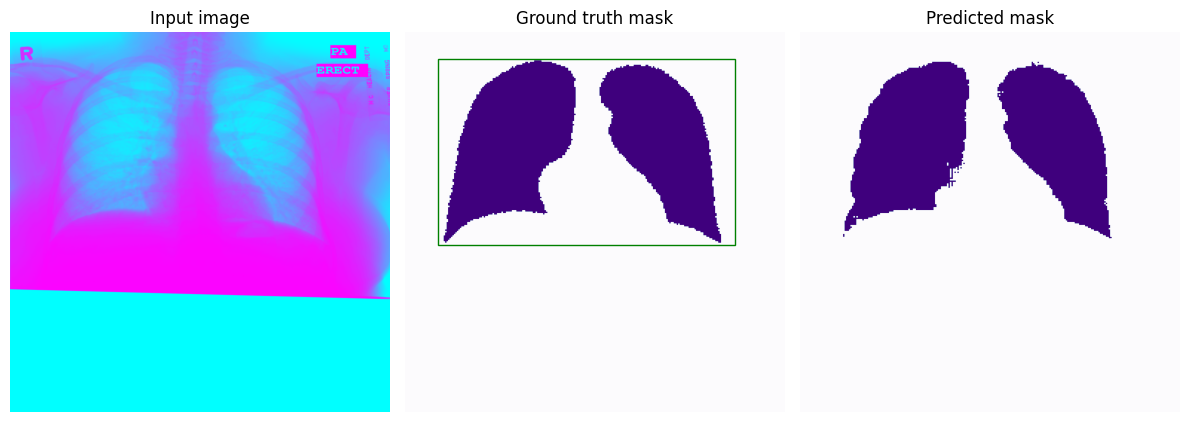

 25%|██▌       | 10/40 [00:04<00:11,  2.56it/s]

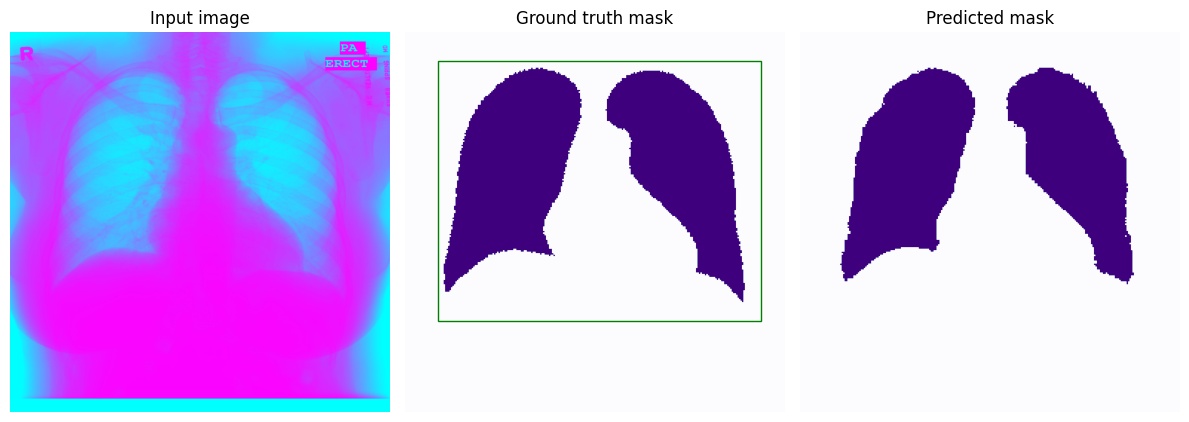

 50%|█████     | 20/40 [00:08<00:07,  2.57it/s]

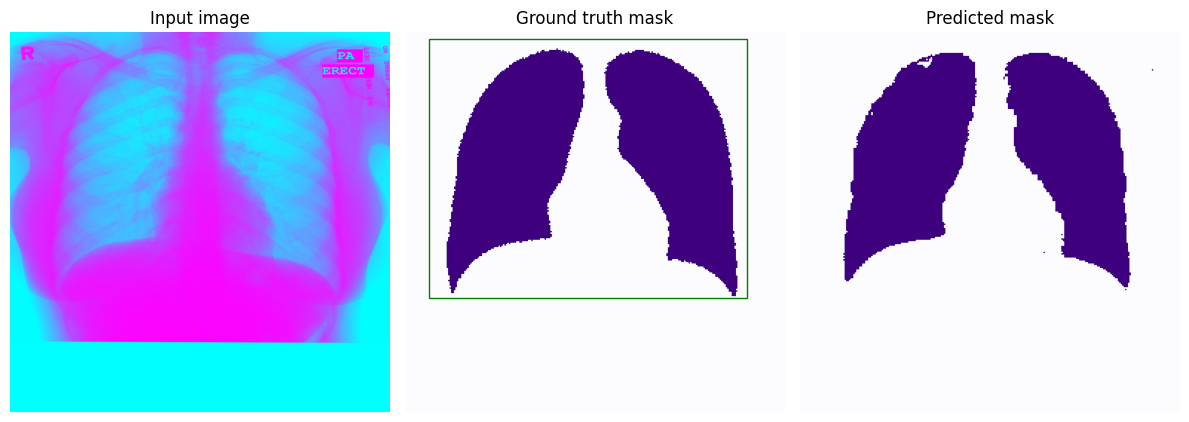

 75%|███████▌  | 30/40 [00:12<00:03,  2.52it/s]

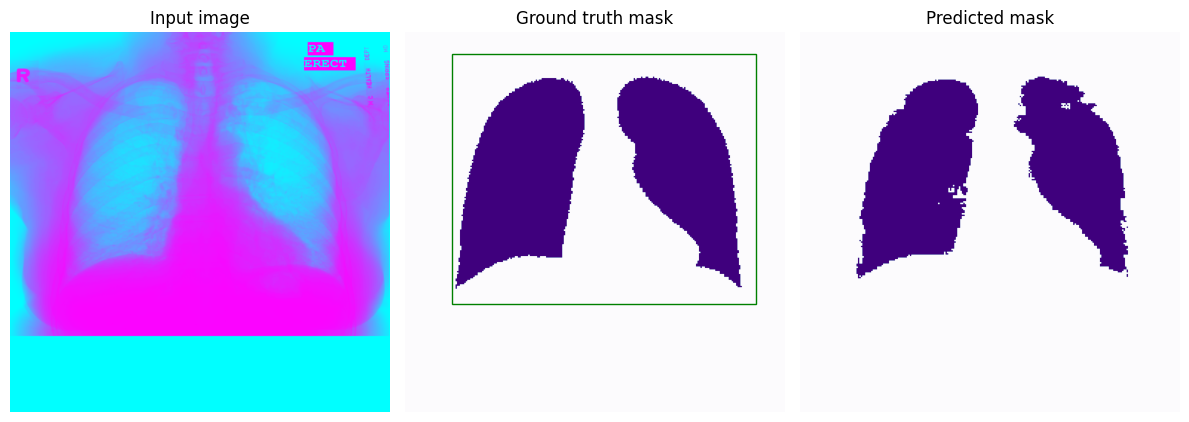

100%|██████████| 40/40 [00:17<00:00,  2.35it/s]

Test Loss: 0.3355050731450319, Test Acc: 0.9631372451782226, Test Dice: 0.9333318039774895, Test IoU: 0.8778500005602836


In [29]:
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
loss_fn = lungLoss()

# Load the best model weights
model.load_state_dict(torch.load("best_model_weights.pth"))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize lists to store test metrics
test_losses = []
test_acc, test_dice, test_iou = [], [], []

# Initialize lists to store test metrics
test_data = []

# No gradient updates
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader)):
        # Get the input and ground truth from the test batch
        images = batch["pixel_values"].to(device)
        masks = batch["ground_truth_mask"].to(device)

        # Forward pass: predict masks using the model
        outputs = model(pixel_values=images,
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = masks.float().unsqueeze(1)
        if ground_truth_masks.ndim == 5:
            ground_truth_masks = ground_truth_masks.squeeze(2)
        ground_truth_masks = F.interpolate(ground_truth_masks, size=predicted_masks.shape[-2:], mode='nearest')

        # Calculate the loss
        test_loss = loss_fn(predicted_masks, ground_truth_masks)
        test_losses.append(test_loss.item())

        # Calculate metrics
        accuracy, dice, iou = calculate_metrics(predicted_masks, ground_truth_masks)
        test_acc.append(accuracy)
        test_dice.append(dice)
        test_iou.append(iou)

        # Plotting for the last batch
        if i % 10 == 0:
            # clear_output(wait=True)
            fig, axs = plt.subplots(1, 3, figsize=(12, 5))
            xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')

            # Input image
            axs[0].set_title('Input image')
            axs[0].imshow(images[0,1].cpu().numpy(), cmap='cool')
            axs[0].axis('off')

            # Ground truth mask
            axs[1].set_title('Ground truth mask')
            axs[1].imshow(ground_truth_masks[0].cpu().numpy().squeeze(), cmap='Purples')
            axs[1].add_patch(rect)
            axs[1].axis('off')

            # Predicted mask
            predicted_seg = torch.sigmoid(predicted_masks[0]).detach().cpu().numpy().squeeze()
            predicted_seg = (predicted_seg > 0.5).astype(np.uint8)
            axs[2].set_title('Predicted mask')
            axs[2].imshow(predicted_seg, cmap='Purples')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

        # Collect metrics for each batch
        test_data.append({
            "batch": i,
            "test_loss": test_loss.item(),
            "test_acc": accuracy,
            "test_dice": dice,
            "test_iou": iou
        })

# Convert all test data to a DataFrame
test_metrics_df = pd.DataFrame(test_data)

# Save the DataFrame to a CSV file
test_metrics_df.to_csv('test_metrics.csv', index=False)

# Calculate mean stats for the entire test set and print them
mean_test_loss = test_metrics_df['test_loss'].mean()
mean_test_acc = test_metrics_df['test_acc'].mean()
mean_test_dice = test_metrics_df['test_dice'].mean()
mean_test_iou = test_metrics_df['test_iou'].mean()

print(f'Test Loss: {mean_test_loss}, Test Acc: {mean_test_acc}, Test Dice: {mean_test_dice}, Test IoU: {mean_test_iou}')

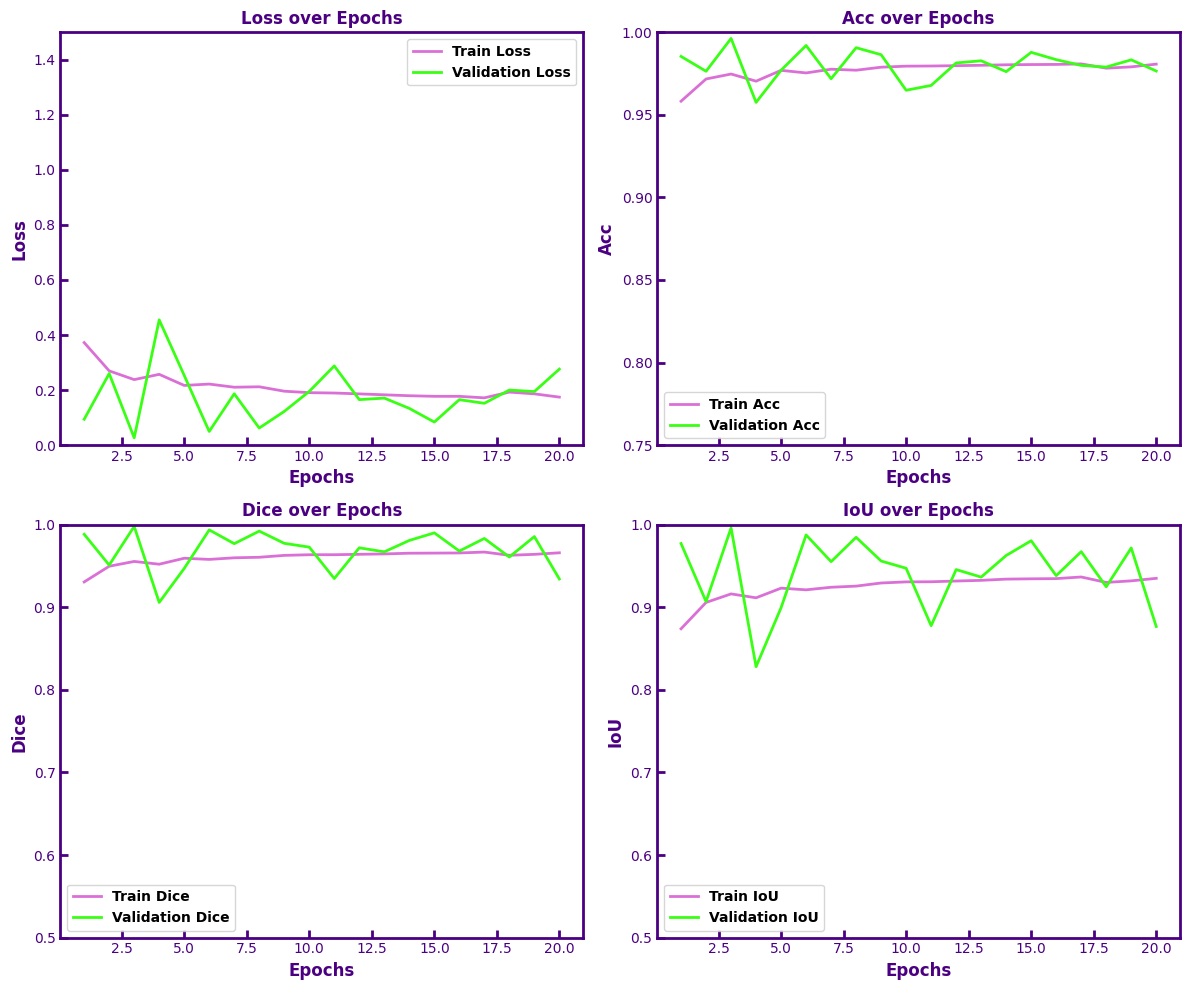

In [26]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains all the required columns.
# Replace 'df' with the actual name of your DataFrame variable.

# Defining colors
dark_purple = "#4B0082"  # Dark Purple for axes and labels
light_purple = "#DA70D6"  # Light Purple for training lines
fluorescent_green = "#39FF14"  # Fluorescent Green for validation lines

# Setting font parameters
font_params = {'weight': 'bold', 'size': 12}

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for ax, metric, y_lim in zip(
    axes.flatten(),
    ['Loss', 'Acc', 'Dice', 'IoU'],
    [(0.0, 1.5), (0.75, 1.0), (0.5, 1.0), (0.5, 1.0)]
):
    # Plotting data
    ax.plot(metrics_df['epoch'], metrics_df['train_' + metric.lower()], label='Train ' + metric, color=light_purple, linewidth=2)
    ax.plot(metrics_df['epoch'], metrics_df['val_' + metric.lower()], label='Validation ' + metric, color=fluorescent_green, linewidth=2)

    # Setting title and labels with custom font
    ax.set_title(metric + ' over Epochs', color=dark_purple, fontdict=font_params)
    ax.set_xlabel('Epochs', color=dark_purple, fontdict=font_params)
    ax.set_ylabel(metric, color=dark_purple, fontdict=font_params)

    # Adjusting y-axis limits
    ax.set_ylim(y_lim)

    # Customizing ticks
    ax.tick_params(axis='both', colors=dark_purple, labelsize=10, direction='in', length=6, width=2)

    # Removing grid
    ax.grid(False)

    # Setting legend with larger font
    legend = ax.legend(prop={'size': 10, 'weight': 'bold'})

    # Enclosing the graphs in a box
    for spine in ax.spines.values():
        spine.set_edgecolor(dark_purple)
        spine.set_linewidth(2)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("/content/xRAY_Segmentation_Performance.png")  # Modify the path as needed
plt.show()